# Técnicas de aprendizaje no supervisado y espectroscopía Raman para descubrir patrones de pigmentación en conchas arqueológicas de moluscos

Trabajo de Fin de Máster para acceder al **Máster en Ciencia de Datos**

Autor: Andrea Pérez Asensio

Director: Adolfo Cobo García

Co-Director: David Cuenca Solana

El objetivo principal de este trabajo es el de analizar espectros Raman de conchas de moluscos para poder estudiar la coloración de las muestras y predecir el color que tuvieron unas conchas arqueológicas que han perdido el color.

En este *Notebook* se recoge todo el código utilizado en el análisis de los espectros Raman.

# 1. Carga de paquetes y de datos
Se realiza la importación de los paquetes utilizados y se cargan los datos. Se realiza un preprocesado que consiste en la etiquetación y concatenación de los datos, obteniendo un *DataFrame* de *pandas* con un multi-índice

In [1]:
import numpy as np
import pandas as pd
#%matplotlib inline
import re
import os
import math
import numpy as np
import pandas as pd
import joblib
import warnings
import time
import matplotlib.pyplot as plt

# Importamos nuestras funciones
import sys
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
from sklearn.decomposition import PCA

print("Todos los paquetes necesarios han sido importados")


C:\Users\perezandrea.UNICAN\AppData\Roaming\Python\Python311\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Todos los paquetes necesarios han sido importados


## 1.1. Carga de los datos.

Se cargan los datos obtenidos tanto por la Sonda de 532nm como los medidos utilizando el micoscópio Nanobase.
Los CSV que se cargan contienen los espectros preprocesados de las diferentes conchas. Para más información sobre el preprocesado elegido consulte **procesado_nanobase.ipynb** y **procesado_sonda532nm.ipynb**

In [2]:
# Cargamos todos los datasets 
data_sonda_2023_Matlab = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2023_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])
data_sonda_2024_Matlab = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2024_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])
data_sonda_2024_Python = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2024_preprocesadoPython.csv', index_col=[0,1,2,3,4,5,6,7])
data_nanobase = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\\nanobasepreprocesado.csv', index_col=[0])


# data_sonda_2023_Matlab= pd.read_csv('/Users/drea/Library/CloudStorage/OneDrive-UNICAN/Escritorio/Conchas/CSV_final/data_sonda_2023_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])
# data_sonda_2024_Matlab= pd.read_csv('/Users/drea/Library/CloudStorage/OneDrive-UNICAN/Escritorio/Conchas/CSV_final/data_sonda_2024_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])
# data_sonda_2024_Python= pd.read_csv('/Users/drea/Library/CloudStorage/OneDrive-UNICAN/Escritorio/Conchas/CSV_final/data_sonda_2024_preprocesadoPython.csv', index_col=[0,1,2,3,4,5,6,7])
# data_nanobase = pd.read_csv('/Users/drea/Library/CloudStorage/OneDrive-UNICAN/Escritorio/Conchas/CSV_final/nanobasepreprocesado.csv', index_col=[0])

In [3]:
data_nanobase_muestras = data_nanobase.index.get_level_values("Muestra").unique().tolist()
data_nanobase_muestras

['LIT1', 'LIT2', 'LIT3', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1', 'LIT4']

In [4]:
data_sonda_2024_Matlab_muestras = data_sonda_2024_Matlab.index.get_level_values("Muestra").unique().tolist()
data_sonda_2024_Python_muestras = data_sonda_2024_Python.index.get_level_values("Muestra").unique().tolist()
data_sonda_2023_Matlab_muestras = data_sonda_2023_Matlab.index.get_level_values("Muestra").unique().tolist()
data_nanobase_muestras = data_nanobase.index.get_level_values("Muestra").unique().tolist()

print("Las muestras de 2024 en Matlab son: ", data_sonda_2024_Matlab_muestras)
print("Las muestras de 2024 en Python son: ", data_sonda_2024_Python_muestras)
print("Las muestras de 2023 en Matlab son: ", data_sonda_2023_Matlab_muestras)
print("Las muestras de Nanobase son: ", data_nanobase_muestras)


Las muestras de 2024 en Matlab son:  ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1', 'LIT921.1']
Las muestras de 2024 en Python son:  ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1', 'LIT921.1']
Las muestras de 2023 en Matlab son:  ['LIT235.3', 'LIT885.1', 'LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT7']
Las muestras de Nanobase son:  ['LIT1', 'LIT2', 'LIT3', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1', 'LIT4']


In [5]:
print('Las dimensiones de los datasets son: ')
print('Sonda 2023 Matlab: ', data_sonda_2023_Matlab.shape)
print('Sonda 2024 Matlab: ', data_sonda_2024_Matlab.shape)
print('Sonda 2024 Python: ', data_sonda_2024_Python.shape)
print('Nanobase: ', data_nanobase.shape)


Las dimensiones de los datasets son: 
Sonda 2023 Matlab:  (39147, 924)
Sonda 2024 Matlab:  (8045, 923)
Sonda 2024 Python:  (8045, 923)
Nanobase:  (28567, 1223)


In [6]:

# Separamos las muestras LIT7 de 2023 y LIT921 de 2024
#data_sonda_2023_Matlab_LIT7 = data_sonda_2023_Matlab.loc[data_sonda_2023_Matlab.index.get_level_values("Muestra") == 'LIT7']
#data_sonda_2024_Python_LIT921_1 = data_sonda_2024_Python.loc[data_sonda_2024_Python.index.get_level_values("Muestra") == 'LIT921.1']
#data_sonda_2024_Matlab_LIT921#_2 = data_sonda_2024_Matlab.loc[data_sonda_2024_Matlab.index.get_level_values("Muestra") == 'LIT921.1']

# Eliminamos las muestras LIT7 de 2023 y LIT921 de 2024
data_sonda_2023_Matlab = data_sonda_2023_Matlab.loc[data_sonda_2023_Matlab.index.get_level_values("Muestra") != 'LIT7']
#print("Las nuevas muestras de 2023 en Matlab son: ", data_sonda_2023_Matlab.index.get_level_values("Muestra").unique().tolist())
data_sonda_2024_Matlab = data_sonda_2024_Matlab.loc[data_sonda_2024_Matlab.index.get_level_values("Muestra") != 'LIT921.1']
print("Las nuevas muestras de 2024 en Matlab son: ", data_sonda_2024_Matlab.index.get_level_values("Muestra").unique().tolist())
data_sonda_2024_Python = data_sonda_2024_Python.loc[data_sonda_2024_Python.index.get_level_values("Muestra") != 'LIT921.1']
print("Las nuevas muestras de 2024 en Python son: ", data_sonda_2024_Python.index.get_level_values("Muestra").unique().tolist())


# Guarmados los datasets sin las muestras LIT7 de 2023 y LIT921 de 2024
#data_sonda_2023_Matlab_LIT7.to_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2023_LIT7_preprocesadoMatlab.csv', index=True)

Las nuevas muestras de 2024 en Matlab son:  ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
Las nuevas muestras de 2024 en Python son:  ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']


# 2. Estudio de los espectros
## 2.1. Comparativa espectros medios
Se realiza una comparativa sobre los datos medidos utilizando la Sonda Raman en 2023 y 2024. En las siguientes gráficas se representan los espectros medios de cada muestra normalizados y sin normalizar. En el espectro no normalizado se puede observar la diferencia entre las intensidades de la señal, mientras que en normalizado se puede estudiar el ruido.

Espectros medios para las muestras normalizados con SNV


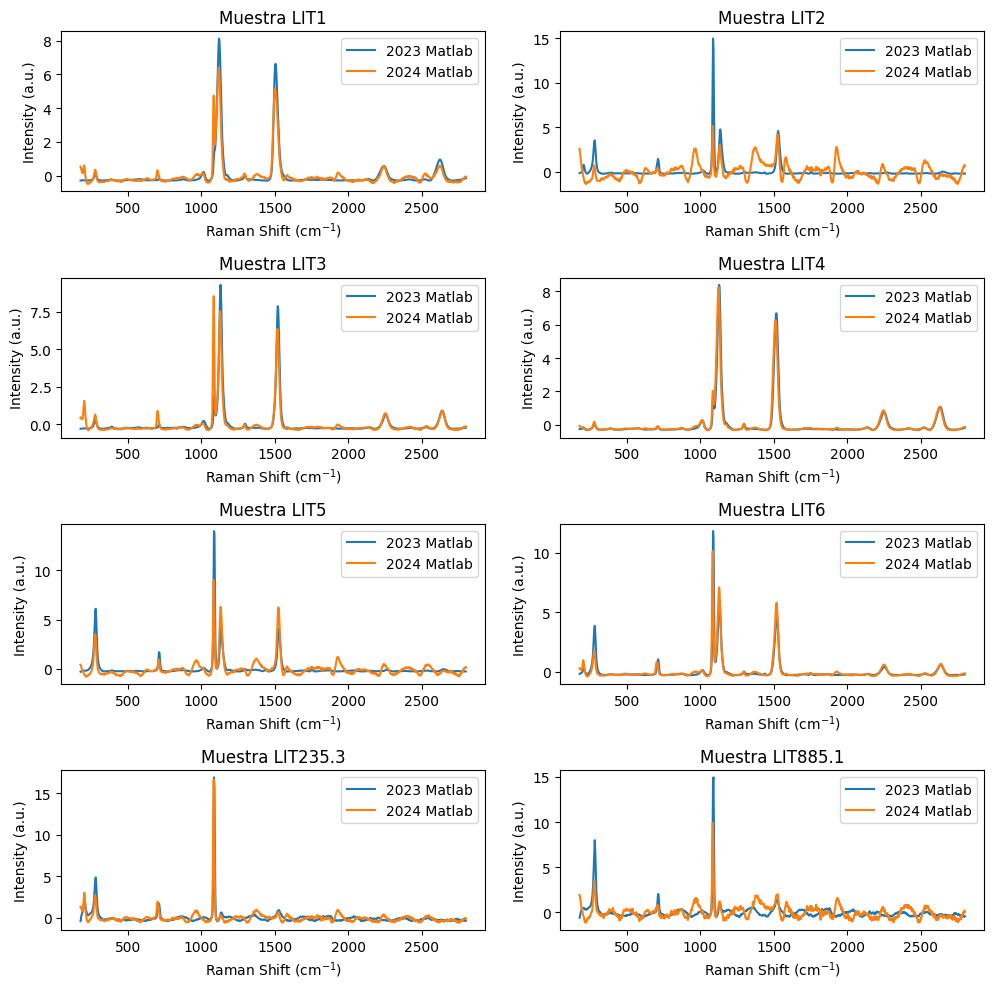

Espectros medios para las muestras sin normalizar


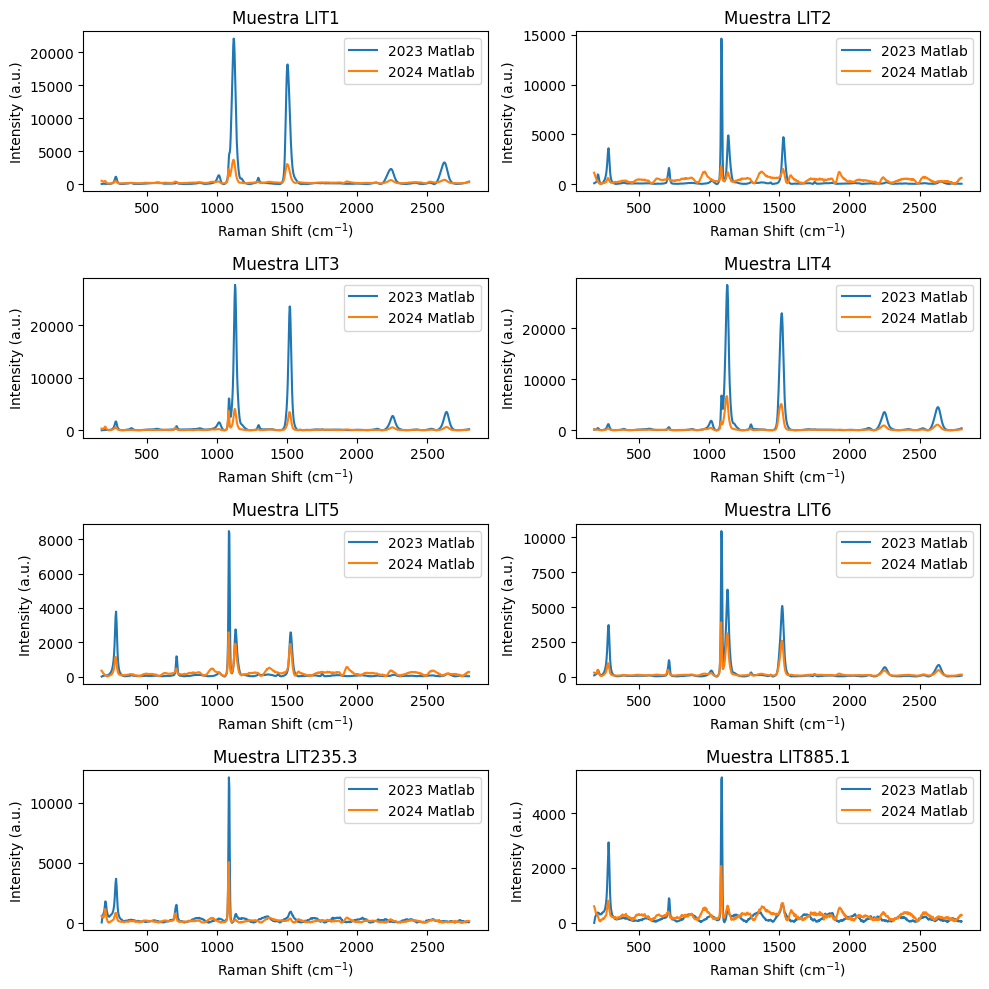

In [7]:
muestras_ordenadas = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3','LIT885.1']

def avg_spectrum_all_8muestras_comp(data1, data2,  muestras):
    fig, axes = plt.subplots(4, 2, figsize=(10, 10))

    # Itera sobre las muestras y representa cada una en su subplot
    for i, muestra in enumerate(muestras):
        # Datos para 2023
        data_muestra1 = data1[data1.index.get_level_values('Muestra') == f'{muestra}']
        wavenumber1 = data_muestra1.columns.get_level_values(0).astype(float)
        mean_intensity1 = data_muestra1.mean(axis=0)

        # Datos para 2024
        data_muestra2 = data2[data2.index.get_level_values('Muestra') == f'{muestra}']
        wavenumber2 = data_muestra2.columns.get_level_values(0).astype(float)
        mean_intensity2 = data_muestra2.mean(axis=0)
        
        # Calcula la posición del subplot en la matriz de subplots
        fila = i // 2
        columna = i % 2

        # Representa el espectro medio en el subplot correspondiente
        axes[fila, columna].plot(wavenumber1, mean_intensity1, label=f'2023 Matlab')
        axes[fila, columna].plot(wavenumber2, mean_intensity2, label=f'2024 Matlab')
        
        axes[fila, columna].set_xlabel('Raman Shift (cm$^{-1}$)')
        axes[fila, columna].set_ylabel('Intensity (a.u.)')
        axes[fila, columna].set_title(f'Muestra {muestra}')

        axes[fila, columna].legend()

    # Ajusta el espaciado entre subplots
    plt.tight_layout()

    # Muestra los subplots
    plt.show()

def SNV(input_data):
    """
    Procesado de datos: SNV (Standard Normal Variate).
    1) Media de cada channel --> axis=1 (todas las columnas).
    2) Se le resta su media a cada "channel" --> axis=0 (todas las filas).
    3) Divide cada channel por su StDev --> axis=1 (todas las columnas).
    :parameter *input_data*: matriz de datos, en formato: "channels(f) x time(c)".
    :return: matriz de datos, una vez normalizados
    """
    data_12 = input_data.sub(input_data.mean(axis=1), axis=0)
    data_snv = data_12.div(input_data.std(axis=1), axis=0)
    return data_snv

data_sonda_2024_Matlab_snv = SNV(data_sonda_2024_Matlab)
# data_sonda_2024_Python_snv = SNV(data_sonda_2024_Python)
data_sonda_2023_Matlab_snv = SNV(data_sonda_2023_Matlab)
data_nanobase_snv = SNV(data_nanobase)

print('Espectros medios para las muestras normalizados con SNV')
avg_spectrum_all_8muestras_comp( data_sonda_2024_Matlab_snv, data_sonda_2023_Matlab_snv, muestras_ordenadas)
print('Espectros medios para las muestras sin normalizar')
avg_spectrum_all_8muestras_comp( data_sonda_2024_Matlab,data_sonda_2023_Matlab, muestras_ordenadas)


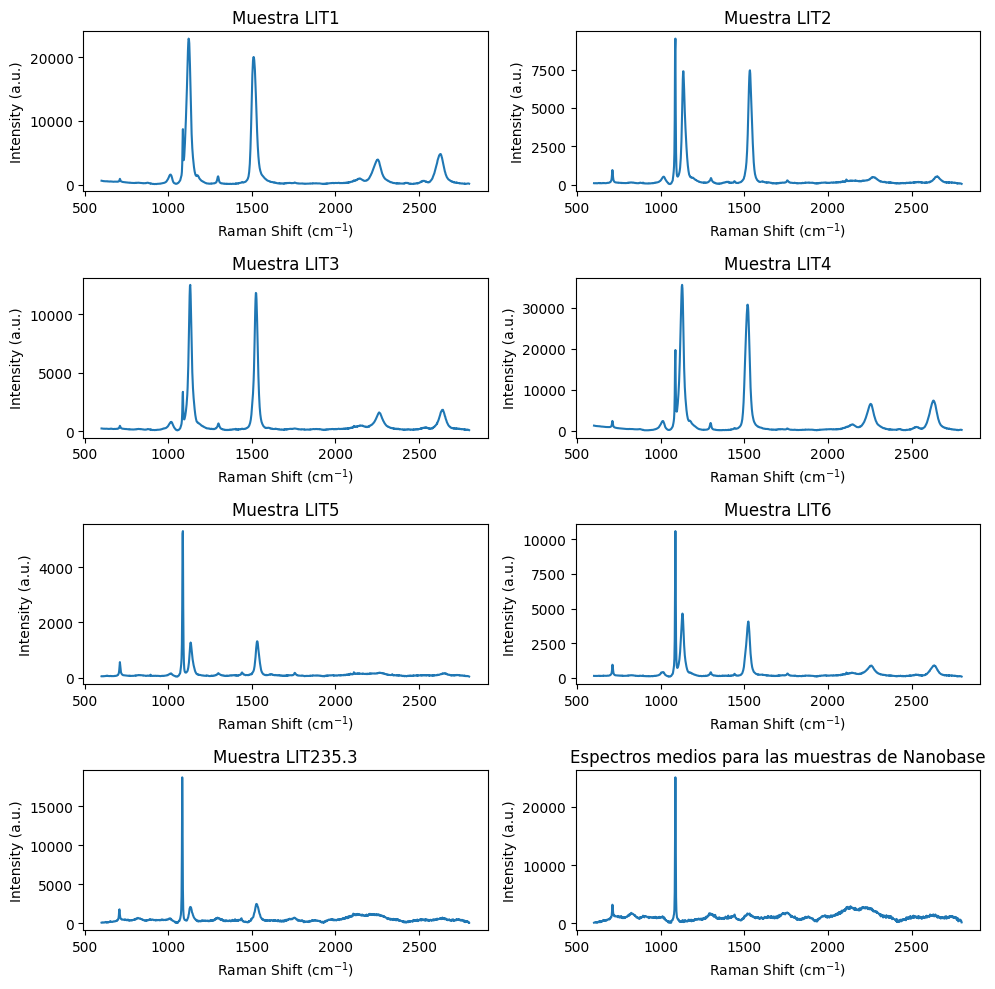

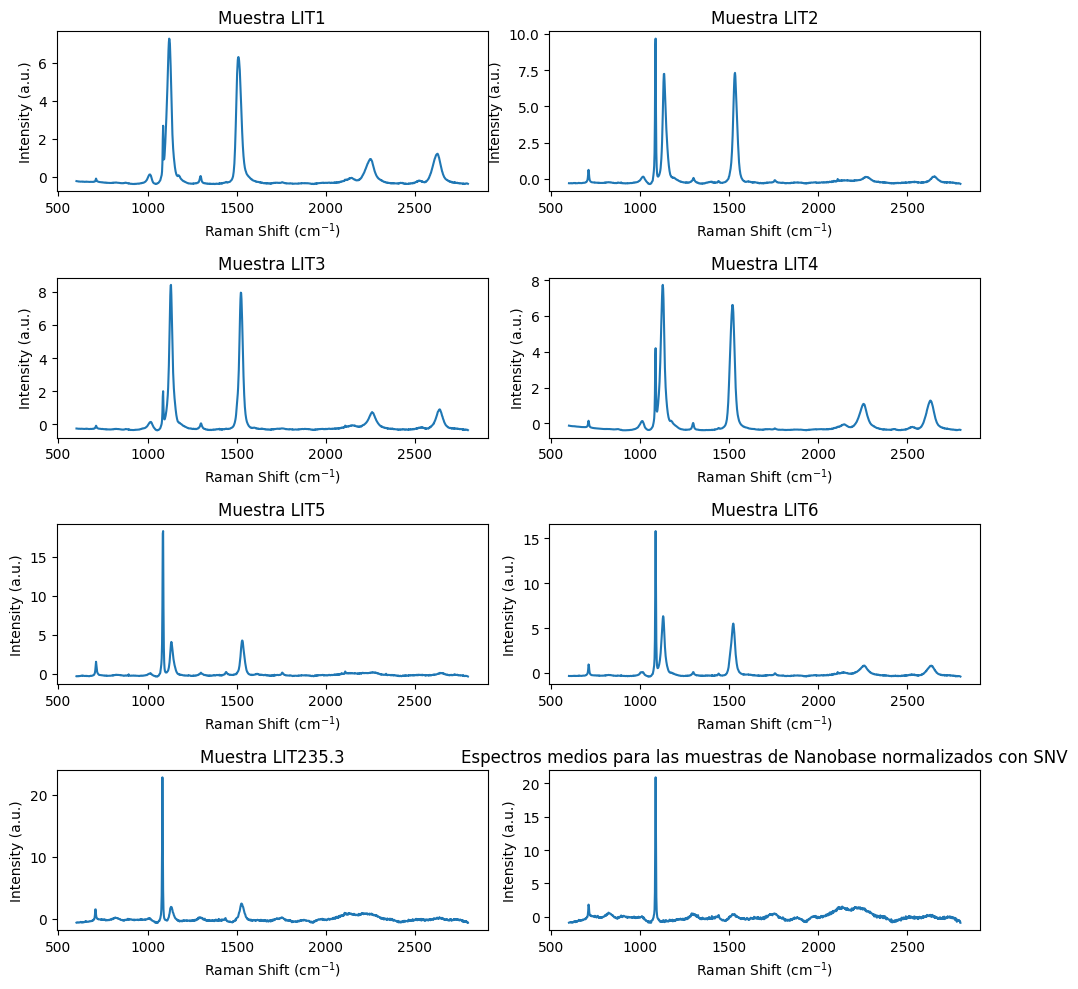

In [8]:
muestras_ordenadas = ['LIT1', 'LIT2', 'LIT3', 'LIT4','LIT5','LIT6','LIT235.3', 'LIT885.1']
def avg_spectrum_all(data,  muestras, titulo):
    #data = pd.concat(dataframes, axis=0)
    fig, axes = plt.subplots(4, 2, figsize=(10, 10))
    # Itera sobre las muestras y representa cada una en su subplot
    for i, muestra in enumerate(muestras):
        data_muestra = data[data.index.get_level_values('Muestra') == f'{muestra}']
        wavenumber = data_muestra.columns.get_level_values(0).astype(float)
        # Calcula las intensidades medias para cada número de onda
        mean_intensity = data_muestra.mean(axis=0)


        # Calcula la posición del subplot en la matriz de subplots
        fila = i // 2
        columna = i % 2

        # Representa el espectro medio en el subplot correspondiente
        axes[fila, columna].plot(wavenumber, mean_intensity, label=f'Muestra {muestra}')
        axes[fila, columna].set_xlabel('Raman Shift (cm$^{-1}$)')
        axes[fila, columna].set_ylabel('Intensity (a.u.)')
        axes[fila, columna].set_title(f'Muestra {muestra}')


    # Ajusta el espaciado entre subplots
    plt.tight_layout()
    plt.title(titulo)


    # Muestra los subplots
    plt.show()

avg_spectrum_all(data_nanobase, muestras_ordenadas, titulo = 'Espectros medios para las muestras de Nanobase')
avg_spectrum_all(data_nanobase_snv, muestras_ordenadas, titulo = 'Espectros medios para las muestras de Nanobase normalizados con SNV')

# 3. Clusterización



## 3.1. Elección del número de clusters.
Para la elección del número de clusters utilizamos el método del codo

In [9]:
from scipy.cluster.hierarchy import linkage
def elbow_method (data, k_values, metodo_clustering, titulo):
     wcss = [] # Suma de los cuadrados de la distancia
     if metodo_clustering == 'K-Means':
           for k in k_values:
                model = KMeans(n_clusters=k)
                model.fit(data)
                wcss.append(model.inertia_)
                # La WCSS se calcula sumando la distancia al cuadrado de cada punto al centroide 
                # de su cluster asignado y sumando estos 
                # valores para todos los clusters. 
                # Esencialmente, mide la dispersión dentro de cada cluster.
     elif metodo_clustering == 'Agglomerative':
           for k in k_values:
                model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
                labels = model.fit_predict(data)
                linkage_matrix = linkage(data, method='ward')
                wcss.append(sum([d**2 for d in linkage_matrix[:, 2]]))
                #La WCSS se calcula sumando la distancia al cuadrado de cada punto al centroide
                #  del cluster final al que pertenece. La matriz de enlace se utiliza para
                #  determinar a qué cluster final se asigna cada punto.
     else:
        raise ValueError("Método de clustering no válido. Use 'K-Means' o 'Agglomerative'.")
        return
     

    # Graficar el método del codo
     plt.plot(k_values, wcss, marker='o')
     plt.xlabel('Número de Clusters (K)')
     plt.ylabel('WCSS')
     plt.title(titulo)

warnings.filterwarnings("ignore")

In [10]:
# elbow_method(data_sonda_2024_Matlab, range(1,15),"K-Means", 'Método del codo utilizando el dataset 2024 Matlab')


In [11]:
# elbow_method(data_sonda_2024_Python, range(1,15),"K-Means", 'Método del codo utilizando el dataset 2024 Python')

Atendiendo a la gráfica representada anteriormente podemos observar que el número óptimo de clústers sería entorno a 5-6, ya que es en ese punto cuando la curva empieza a aplanarse

In [12]:
# elbow_method(data_sonda_2023_Matlab, range(1,15),"K-Means", 'Método del codo utilizando el dataset 2023 Matlab')

En esta gráfica podemos apreciar que el valor en el que empeiza a planarse se acerca más a 7-8

In [13]:
# elbow_method(data_nanobase, range(1,15),"K-Means", 'Método del codo utilizando el dataset Nanobase')

## 3.2 Aplicación de clusterings

In [14]:
def plot_clusters_class_8muestras_4col(data, muestras, tipo_cluster="Cluster_KMeans", color_tipo='#1f77b4', title = "K-Means Clustering para Nanobase"):

    # Crear subplots con el diseño deseado
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    todos_clusters = sorted(data.index.get_level_values(tipo_cluster).unique().tolist())
    indices_cluster = np.arange(len(todos_clusters))

    # Realizamos para cada muestra
    for i, muestra in enumerate(muestras):
        # Separamos los espectros de la muestra
        data_muestra = data[data.index.get_level_values("Muestra") == muestra]

        # Contamos el número de veces de espectros correspondientes al clúster
        cluster_counts = data_muestra.index.get_level_values(tipo_cluster).value_counts().reindex(todos_clusters, fill_value=0)

        # Creamos un barplot
        fila = i % 2
        columna = i // 2

        # Verificamos si la muestra es "Arq 235" o "Arq 885" para cambiar el color a rojo
        color_actual = 'red' if muestra in [ 'LIT235.3', 'LIT885.1'] else color_tipo
        bar_cluster = axes[fila, columna].bar(indices_cluster, cluster_counts, width=0.9, label=tipo_cluster, color=color_actual)

        # Editamos el título para cada muestra:
        axes[fila, columna].set_title(f"{muestra}")
        axes[fila, columna].set_xticks(indices_cluster)
        axes[fila, columna].set_xticklabels(todos_clusters)
        axes[fila, columna].set_xlabel("Cluster")
        axes[fila, columna].set_ylabel("Number of Spectra")

    # Añado un título
    fig.suptitle(title)

    # Ajustar espaciado entre subplots
    plt.tight_layout()



    plt.show()

### 3.2.1. K-Means

In [15]:
def clustering_K_Means(data, n_clusters):
    """
    Realiza clustering K-Means sobre el dataset proporcionado.
    :parameter *data*: matriz de datos, en formato: "channels(f) x time(c)".
    :parameter *n_clusters*: número de clusters a utilizar.
    :return: modelo de clustering K-Means entrenado.
    """
    t1 = time.time()
    kmeans = KMeans(n_clusters = n_clusters, random_state = 50).fit(data)
    data["Cluster_KMeans"] = kmeans.labels_
    # Convertir la columna Cluster_KMeans en un MultiIndex
    multiindex = pd.MultiIndex.from_frame(data[['Cluster_KMeans']])
    # Añadir el nuevo nivel de índice al multiíndice existente
    data = data.set_index(multiindex, append=True)
    data = data.drop(columns=['Cluster_KMeans'])
    t2 = time.time()
    tiempo = t2 - t1
    return data, tiempo


data_sonda_2024_Matlab_copy = data_sonda_2024_Matlab.copy()
data_sonda_2023_Matlab_copy = data_sonda_2023_Matlab.copy()
# data_sonda_2024_Python_copy = data_sonda_2024_Python.copy()
data_nanobase_copy = data_nanobase.copy()

data_sonda_2024_Matlab_copy, tiempo_2024_Matlab_KMeans = clustering_K_Means(data_sonda_2024_Matlab_copy, 5)
data_sonda_2023_Matlab_copy, tiempo_2023_Matlab_KMeans = clustering_K_Means(data_sonda_2023_Matlab_copy, 5)
# data_sonda_2024_Python_copy, tiempo_2024_Python_Kmeans = clustering_K_Means(data_sonda_2024_Python_copy, 5)
data_nanobase_copy, tiempo_nanobase_KMeans = clustering_K_Means(data_nanobase_copy, 5)

print(f"Tiempo de ejecución de clustering K-Means para dataset de 2024 Matlab: {tiempo_2024_Matlab_KMeans:.2f} segundos")
print(f"Tiempo de ejecución de clustering K-Means para dataset de 2023 Matlab: {tiempo_2023_Matlab_KMeans:.2f} segundos")
# print(f"Tiempo de ejecución de clustering K-Means para dataset de 2024 Python: {tiempo_2024_Python_Kmeans:.2f} segundos")
print(f"Tiempo de ejecución de clustering K-Means para dataset de Nanobase: {tiempo_nanobase_KMeans:.2f} segundos")


Tiempo de ejecución de clustering K-Means para dataset de 2024 Matlab: 0.94 segundos
Tiempo de ejecución de clustering K-Means para dataset de 2023 Matlab: 9.58 segundos
Tiempo de ejecución de clustering K-Means para dataset de Nanobase: 10.64 segundos


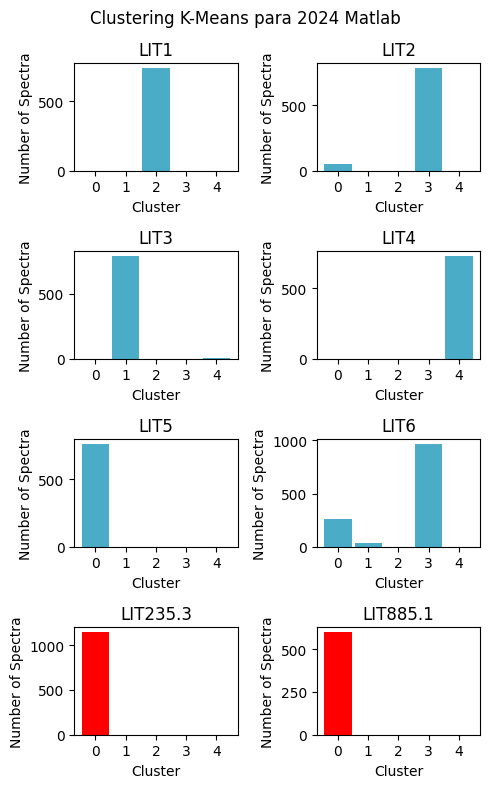

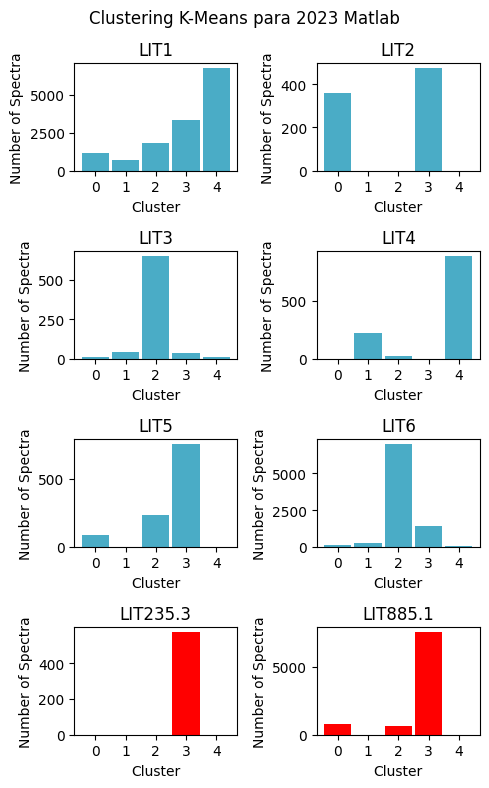

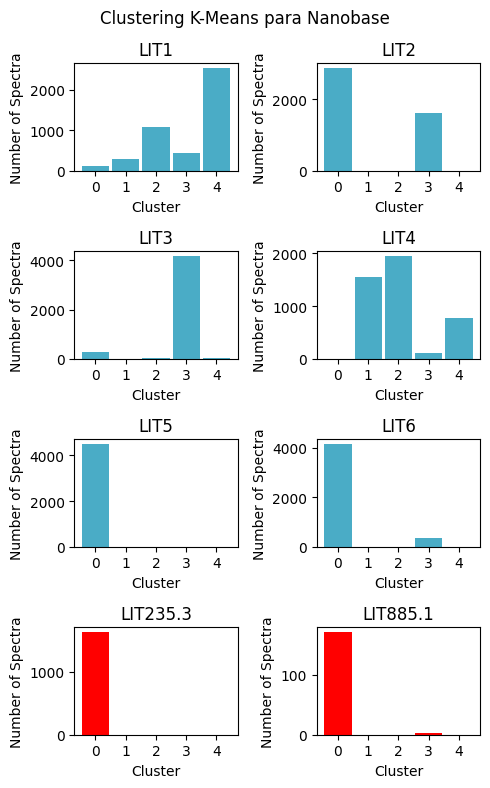

In [16]:
def plot_clusters_class_8muestras_2col(data, muestras, tipo_cluster='Cluster_KMeans', title= 'Distribución de los Clústers en las 8 muestras', color_tipo = '#1f77b4'):

    # Crear subplots con el diseño deseado
    fig, axes = plt.subplots(4, 2, figsize=(5, 8))


    todos_clusters = sorted(data.index.get_level_values(tipo_cluster).unique().tolist())

    indices_cluster = np.arange(len(todos_clusters))

    # Realizamos para cada muestra
    for i, muestra in enumerate(muestras):
        # Separamos los espectros de la muestra
        data_muestra = data[data.index.get_level_values("Muestra") == muestra]

        # Contamos el número de veces de espectros correspondientes al clúster
        cluster_counts = data_muestra.index.get_level_values(tipo_cluster).value_counts().reindex(todos_clusters, fill_value=0)
        color_actual = 'red' if muestra in [ 'LIT235.3', 'LIT885.1'] else color_tipo
        # Creamos un barplot
        row = i // 2
        col = i % 2
        axes[row, col].bar(indices_cluster, cluster_counts, width=0.9, label=tipo_cluster, color = color_actual)
        
        # Editamos el título para cada muestra
        axes[row, col].set_title(f"{muestra}")
        axes[row, col].set_xticks(indices_cluster)
        axes[row, col].set_xticklabels(todos_clusters)
        axes[row, col].set_xlabel("Cluster")
        axes[row, col].set_ylabel("Number of Spectra")


    # Añado un título general
    fig.suptitle(title)

    # Ajustar espaciado entre subplots
    plt.tight_layout()
    plt.show()

muestras_ordenadas = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3','LIT885.1']

plot_clusters_class_8muestras_2col(data_sonda_2024_Matlab_copy, muestras_ordenadas,'Cluster_KMeans', title = "Clustering K-Means para 2024 Matlab", color_tipo = "#4AACC6" )
plot_clusters_class_8muestras_2col(data_sonda_2023_Matlab_copy, muestras_ordenadas,'Cluster_KMeans', title = "Clustering K-Means para 2023 Matlab", color_tipo = "#4AACC6")
# plot_clusters_class_8muestras_2col(data_sonda_2024_Python_copy, muestras_ordenadas,'Cluster_KMeans', title = "Clustering K-Means para 2024 Python", color_tipo = "#4AACC6")
plot_clusters_class_8muestras_2col(data_nanobase_copy, muestras_ordenadas,'Cluster_KMeans', title = "Clustering K-Means para Nanobase", color_tipo = "#4AACC6")


# plot_clusters_class_8muestras_4col(data_sonda_2024_Matlab_copy, muestras_ordenadas,tipo_cluster="Cluster_KMeans", title = "K-Means Clustering para 2024 Matlab")
# plot_clusters_class_8muestras_4col(data_sonda_2023_Matlab_copy, muestras_ordenadas,tipo_cluster="Cluster_KMeans", title = "K-Means Clustering para 2023 Matlab")
# plot_clusters_class_8muestras_4col(data_sonda_2024_Python_copy, muestras_ordenadas,tipo_cluster="Cluster_KMeans", title = "K-Means Clustering para 2024 Python")
# plot_clusters_class_8muestras_4col(data_nanobase_copy, muestras_ordenadas,tipo_cluster="Cluster_KMeans", title = "K-Means Clustering para Nanobase")

#### Correlación

In [17]:

def calculo_correlacion(data, muestras, tipo_cluster):
    frecuencias = []
    todos_clusters = sorted(data.index.get_level_values(tipo_cluster).unique().tolist())

    # Realizamos para cada muestra
    for muestra in muestras:
        # Separamos los espectros de la muestra
        data_muestra = data[data.index.get_level_values("Muestra") == muestra]
        # Contamos el número de veces de espectros correspondientes al clúster
        cluster_counts = data_muestra.index.get_level_values(tipo_cluster).value_counts().reindex(todos_clusters, fill_value=0)
        frecuencias.append(cluster_counts)

    # Calcular la media de cada vector
    medias = [np.mean(frec) for frec in frecuencias]

    # Calcular la matriz de correlación
    matriz_correlacion = np.corrcoef(frecuencias)

    # Crear una tabla para almacenar las correlaciones de Pearson
    correlaciones = []

    for i, muestra in enumerate(muestras[:-2]):
        correlacion_8 = np.corrcoef(frecuencias[i], frecuencias[-1])[0, 1]
        correlacion_7 = np.corrcoef(frecuencias[i], frecuencias[-2])[0, 1]
        correlaciones.append([muestra, correlacion_7, correlacion_8])

    # Convertir la lista de correlaciones en un DataFrame de pandas
    df_correlaciones = pd.DataFrame(correlaciones, columns=["Muestra", "Correlación con Muestra 7", "Correlación con Muestra 8"])

    # Encontrar la correlación más alta con las muestras 7 y 8
    max_correlacion_7 = df_correlaciones["Correlación con Muestra 7"].max()
    muestra_max_corr_7 = df_correlaciones.loc[df_correlaciones["Correlación con Muestra 7"].idxmax(), "Muestra"]
    
    max_correlacion_8 = df_correlaciones["Correlación con Muestra 8"].max()
    muestra_max_corr_8 = df_correlaciones.loc[df_correlaciones["Correlación con Muestra 8"].idxmax(), "Muestra"]

    # Imprimir las correlaciones más altas
    print(f"La correlación más alta con la Muestra 7 es {max_correlacion_7:.2f}, con la Muestra: {muestra_max_corr_7}")
    print(f"La correlación más alta con la Muestra 8 es {max_correlacion_8:.2f}, con la Muestra: {muestra_max_corr_8}")

    return matriz_correlacion, df_correlaciones

In [18]:

# Ejemplo de uso
print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Matlab")
data = data_sonda_2024_Matlab_copy.copy()
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_2024_Matlab_KMeans = calculo_correlacion(data, muestras, tipo_cluster="Cluster_KMeans")
print(df_correlaciones_2024_Matlab_KMeans)

print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2023 Matlab")
data = data_sonda_2023_Matlab_copy.copy()
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_2023_Matlab_KMeans = calculo_correlacion(data, muestras, tipo_cluster="Cluster_KMeans")
print(df_correlaciones_2023_Matlab_KMeans)

# print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Python")
# data = data_sonda_2024_Python_copy.copy()
# muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
# matriz_correlacion, df_correlaciones_2024_Python_KMeans = calculo_correlacion(data, muestras, tipo_cluster="Cluster_KMeans")
# print(df_correlaciones_2024_Python_KMeans)

print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de Nanobase")
data = data_nanobase_copy.copy()
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_nanobase_KMeans = calculo_correlacion(data, muestras, tipo_cluster="Cluster_KMeans")
print(df_correlaciones_nanobase_KMeans)

Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Matlab
La correlación más alta con la Muestra 7 es 1.00, con la Muestra: LIT5
La correlación más alta con la Muestra 8 es 1.00, con la Muestra: LIT5
  Muestra  Correlación con Muestra 7  Correlación con Muestra 8
0    LIT1                  -0.250000                  -0.250000
1    LIT2                  -0.184698                  -0.184698
2    LIT3                  -0.250791                  -0.250791
3    LIT4                  -0.250000                  -0.250000
4    LIT5                   0.999999                   0.999999
5    LIT6                   0.011126                   0.011126
Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2023 Matlab
La correlación más alta con la Muestra 7 es 0.95, con la Muestra: LIT5
La correlación más alta con la Muestra 8 es 0.97, con la Muestra: LIT5
  Muestra  Correlación con Muestra 7  Correlación con Muestra 8
0    LIT1                   0.1306

### 3.2.2. Agglomerative



In [19]:
# def clustering_AHC(data, n_clusters):
#     """
#     Realiza clustering AHC sobre el dataset proporcionado.
#     :parameter *data*: matriz de datos, en formato: "channels(f) x time(c)".
#     :parameter *n_clusters*: número de clusters a utilizar.
#     :return: modelo de clustering K-Means entrenado.
#     """
#     t1 = time.time()
#     agg_clustering = AgglomerativeClustering(n_clusters = n_clusters, affinity='euclidean', linkage='ward')
#     data["Cluster_AHC"] = agg_clustering.fit_predict(data)
#     # Convertir la columna Cluster_AHC en un MultiIndex
#     multiindex = pd.MultiIndex.from_frame(data[['Cluster_AHC']])
#     # Añadir el nuevo nivel de índice al multiíndice existente
#     data = data.set_index(multiindex, append=True)
#     data = data.drop(columns=['Cluster_AHC'])
#     t2 = time.time()
#     tiempo = t2 - t1
#     return data, tiempo


# data_sonda_2024_Matlab_copy, tiempo_2024_Matlab_AHC = clustering_AHC(data_sonda_2024_Matlab_copy, 5)
# data_sonda_2023_Matlab_copy, tiempo_2023_Matlab_AHC = clustering_AHC(data_sonda_2023_Matlab_copy, 7)
# data_sonda_2024_Python_copy, tiempo_2024_Python_AHC = clustering_AHC(data_sonda_2024_Python_copy, 5)
# data_nanobase_copy, tiempo_nanobase_AHC = clustering_AHC(data_nanobase_copy, 5)

# print(f"Tiempo de ejecución de clustering AHC para dataset de 2024 Matlab: {tiempo_2024_Matlab_AHC:.2f} segundos")
# print(f"Tiempo de ejecución de clustering AHC para dataset de 2023 Matlab: {tiempo_2023_Matlab_AHC:.2f} segundos")
# print(f"Tiempo de ejecución de clustering AHC para dataset de 2024 Python: {tiempo_2024_Python_AHC:.2f} segundos")
# print(f"Tiempo de ejecución de clustering AHC para dataset de Nanobase: {tiempo_nanobase_AHC:.2f} segundos")

In [20]:
# plot_clusters_class_8muestras_2col(data_sonda_2024_Matlab_copy, muestras_ordenadas,'Cluster_AHC', title = "Clustering AHC para 2024 Matlab", color_tipo = "#9BBB59")
# plot_clusters_class_8muestras_2col(data_sonda_2023_Matlab_copy, muestras_ordenadas,'Cluster_AHC', title = "Clustering AHC para 2023 Matlab", color_tipo = "#9BBB59")
# plot_clusters_class_8muestras_2col(data_sonda_2024_Python_copy, muestras_ordenadas,'Cluster_AHC', title = "Clustering AHC para 2024 Python", color_tipo = "#9BBB59")
# plot_clusters_class_8muestras_2col(data_nanobase_copy, muestras_ordenadas,'Cluster_AHC', title = "Clustering AHC para Nanobase", color_tipo = "#9BBB59")

# plot_clusters_class_8muestras_4col(data_sonda_2024_Matlab_copy, muestras_ordenadas,tipo_cluster="Cluster_AHC", title = "AHC Clustering para 2024 Matlab", color_tipo = "#9BBB59")
# plot_clusters_class_8muestras_4col(data_sonda_2023_Matlab_copy, muestras_ordenadas,tipo_cluster="Cluster_AHC", title = "AHC Clustering para 2023 Matlab", color_tipo = "#9BBB59")
# plot_clusters_class_8muestras_4col(data_sonda_2024_Python_copy, muestras_ordenadas,tipo_cluster="Cluster_AHC", title = "AHC Clustering para 2024 Python", color_tipo = "#9BBB59")
# plot_clusters_class_8muestras_4col(data_nanobase_copy, muestras_ordenadas,tipo_cluster="Cluster_AHC", title = "AHC Clustering para Nanobase", color_tipo = "#9BBB59")


#### Correlacion

In [21]:
# # Ejemplo de uso
# print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Matlab")
# data = data_sonda_2024_Matlab_copy
# muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
# matriz_correlacion, df_correlaciones_2024_Matlab_AHC = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_AHC")
# print(df_correlaciones_2024_Matlab_AHC)

# print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2023 Matlab")
# data = data_sonda_2023_Matlab_copy
# muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
# matriz_correlacion, df_correlaciones_2023_Matlab_AHC = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_AHC")
# print(df_correlaciones_2023_Matlab_AHC)

# print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Python")
# data = data_sonda_2024_Python_copy
# muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
# matriz_correlacion, df_correlaciones_2024_Python_AHC = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_AHC")
# print(df_correlaciones_2024_Python_AHC)

# print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de Nanobase")
# data = data_nanobase_copy
# muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
# matriz_correlacion, df_correlaciones_nanobase_AHC = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_AHC")
# print(df_correlaciones_nanobase_AHC)

### 3.2.4 BIRCH

In [22]:
# def clustering_BIRCH(data, n_clusters):
#     """
#     Realiza clustering BIRCH sobre el dataset proporcionado.
#     :parameter *data*: matriz de datos, en formato: "channels(f) x time(c)".
#     :parameter *n_clusters*: número de clusters a utilizar.
#     :return: modelo de clustering K-Means entrenado.
#     """
#     t1 = time.time()
#     birch_clustering =  Birch(threshold=0.01, n_clusters= n_clusters)
#     data["Cluster_BIRCH"] = birch_clustering.fit_predict(data)
#     # Convertir la columna Cluster_BIRCH en un MultiIndex
#     multiindex = pd.MultiIndex.from_frame(data[['Cluster_BIRCH']])
#     # Añadir el nuevo nivel de índice al multiíndice existente
#     data = data.set_index(multiindex, append=True)
#     data = data.drop(columns=['Cluster_BIRCH'])
#     t2 = time.time()
#     tiempo = t2 - t1
#     return data, tiempo

In [23]:
# data_sonda_2024_Matlab_copy, tiempo_2024_Matlab_BIRCH = clustering_BIRCH(data_sonda_2024_Matlab_copy, 5)
# data_sonda_2023_Matlab_copy, tiempo_2023_Matlab_BIRCH = clustering_BIRCH(data_sonda_2023_Matlab_copy, 7)
# data_sonda_2024_Python_copy, tiempo_2024_Python_BIRCH = clustering_BIRCH(data_sonda_2024_Python_copy, 5)
# data_nanobase_copy, tiempo_nanobase_BIRCH = clustering_BIRCH(data_nanobase_copy, 5)

# print(f"Tiempo de ejecución de clustering AHC para dataset de 2024 Matlab: {tiempo_2024_Matlab_BIRCH:.2f} segundos")
# print(f"Tiempo de ejecución de clustering AHC para dataset de 2023 Matlab: {tiempo_2023_Matlab_BIRCH:.2f} segundos")
# print(f"Tiempo de ejecución de clustering AHC para dataset de 2024 Python: {tiempo_2024_Python_BIRCH:.2f} segundos")
# print(f"Tiempo de ejecución de clustering AHC para dataset de Nanobase: {tiempo_nanobase_BIRCH:.2f} segundos")

In [24]:
# plot_clusters_class_8muestras_2col(data_sonda_2024_Matlab_copy, muestras_ordenadas,'Cluster_BIRCH', title = "Clustering BIRCH para 2024 Matlab", color_tipo = "#F79645")
# plot_clusters_class_8muestras_2col(data_sonda_2023_Matlab_copy, muestras_ordenadas,'Cluster_BIRCH', title = "Clustering BIRCH para 2023 Matlab", color_tipo = "#F79645")
# plot_clusters_class_8muestras_2col(data_sonda_2024_Python_copy, muestras_ordenadas,'Cluster_BIRCH', title = "Clustering BIRCH para 2024 Python", color_tipo = "#F79645")
# plot_clusters_class_8muestras_2col(data_nanobase_copy, muestras_ordenadas,'Cluster_BIRCH', title = "Clustering para BIRCH Nanobase", color_tipo = "#F79645")

# plot_clusters_class_8muestras_4col(data_sonda_2024_Matlab_copy, muestras_ordenadas,tipo_cluster="Cluster_BIRCH", title = "BIRCH Clustering para 2024 Matlab", color_tipo = "#F79645")
# plot_clusters_class_8muestras_4col(data_sonda_2023_Matlab_copy, muestras_ordenadas,tipo_cluster="Cluster_BIRCH", title = "BIRCH Clustering para 2023 Matlab", color_tipo = "#F79645")
# plot_clusters_class_8muestras_4col(data_sonda_2024_Python_copy, muestras_ordenadas,tipo_cluster="Cluster_BIRCH", title = "BIRCH Clustering para 2024 Python", color_tipo = "#F79645")
# plot_clusters_class_8muestras_4col(data_nanobase_copy, muestras_ordenadas,tipo_cluster="Cluster_BIRCH", title = "BIRCH Clustering para Nanobase", color_tipo = "#F79645")



In [25]:
# # Ejemplo de uso
# print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Matlab")
# data = data_sonda_2024_Matlab_copy
# muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
# matriz_correlacion, df_correlaciones_2024_Matlab_BIRCH = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_BIRCH")
# print(df_correlaciones_2024_Matlab_BIRCH)

# print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2023 Matlab")
# data = data_sonda_2023_Matlab_copy
# muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
# matriz_correlacion, df_correlaciones_2023_Matlab_BIRCH = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_BIRCH")
# print(df_correlaciones_2023_Matlab_BIRCH)

# print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2024 Python")
# data = data_sonda_2024_Python_copy
# muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
# matriz_correlacion, df_correlaciones_2024_Python_AHC = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_BIRCH")
# print(df_correlaciones_2024_Python_AHC)

# print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de Nanobase")
# data = data_nanobase_copy
# muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
# matriz_correlacion, df_correlaciones_nanobase_BIRCH = calculo_correlacion(data, muestras, tipo_cluster = "Cluster_BIRCH")
# print(df_correlaciones_nanobase_BIRCH)

# Extra


## PCA

Número de componentes principales necesarios para explicar al menos el 95.0% de la varianza: 334


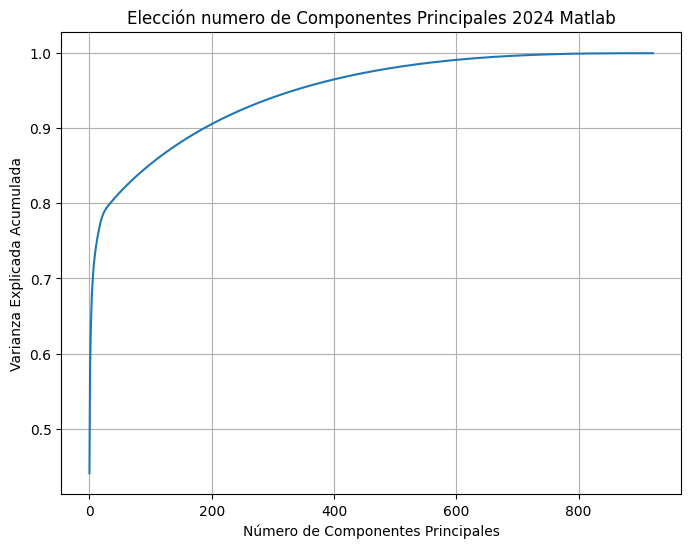

In [26]:
# Escalamos los datos
scaler = StandardScaler()
data_scaled_2024_Matlab_snv = scaler.fit_transform(data_sonda_2024_Matlab_snv)

# Aplicamos PCA
pca_2024_Matlab_snv = PCA()
data_pca_2024_Matlab_snv = pca_2024_Matlab_snv.fit_transform(data_scaled_2024_Matlab_snv)

# Calcular la varianza explicada por cada componente
explained_variance_2024_Matlab_snv = pca_2024_Matlab_snv.explained_variance_ratio_
# Calcular la varianza acumulada
cumulative_variance = np.cumsum(explained_variance_2024_Matlab_snv)

# Establecer el umbral de varianza explicada
threshold = 0.95

# Encontrar el número de componentes necesarios para superar el umbral
num_components = np.argmax(cumulative_variance >= threshold) + 1

print(f"Número de componentes principales necesarios para explicar al menos el {threshold*100}% de la varianza: {num_components}")


# Graficar la varianza explicada acumulada en función del número de componentes
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_2024_Matlab_snv))
plt.xlabel("Número de Componentes Principales")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Elección numero de Componentes Principales 2024 Matlab")
plt.grid(True)
plt.show()

Número de componentes principales necesarios para explicar al menos el 95.0% de la varianza: 565


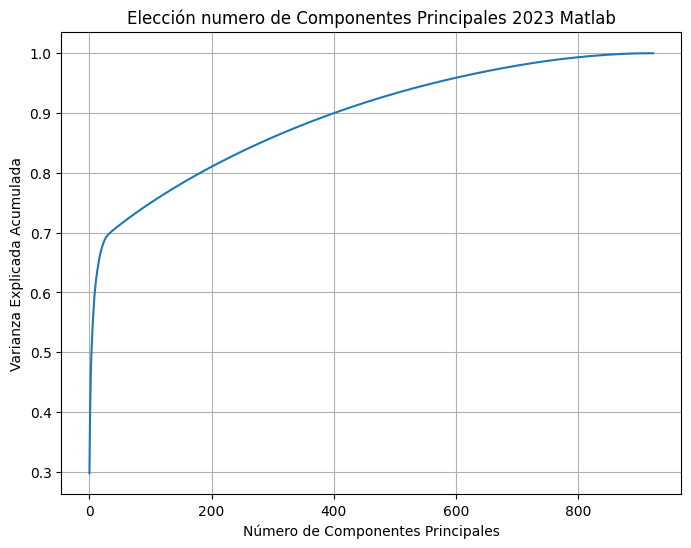

In [27]:
# Escalamos los datos
scaler = StandardScaler()
data_scaled_2023_Matlab_snv = scaler.fit_transform(data_sonda_2023_Matlab_snv)

# Aplicamos PCA
pca_2023_Matlab_snv = PCA()
data_pca_2023_Matlab_snv = pca_2023_Matlab_snv.fit_transform(data_scaled_2023_Matlab_snv)

# Calcular la varianza explicada por cada componente
explained_variance_2023_Matlab_snv = pca_2023_Matlab_snv.explained_variance_ratio_
# Calcular la varianza acumulada
cumulative_variance = np.cumsum(explained_variance_2023_Matlab_snv)

# Establecer el umbral de varianza explicada
threshold = 0.95

# Encontrar el número de componentes necesarios para superar el umbral
num_components = np.argmax(cumulative_variance >= threshold) + 1

print(f"Número de componentes principales necesarios para explicar al menos el {threshold*100}% de la varianza: {num_components}")


# Graficar la varianza explicada acumulada en función del número de componentes
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_2023_Matlab_snv))
plt.xlabel("Número de Componentes Principales")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Elección numero de Componentes Principales 2023 Matlab")
plt.grid(True)
plt.show()

In [28]:
# # Escalamos los datos
# scaler = StandardScaler()
# data_scaled_2024_Python_snv = scaler.fit_transform(data_sonda_2024_Python_snv)

# # Aplicamos PCA
# pca_2024_Python_snv = PCA()
# data_pca_2024_Python_snv = pca_2024_Python_snv.fit_transform(data_scaled_2024_Python_snv)

# # Calcular la varianza explicada por cada componente
# explained_variance_2024_Python_snv = pca_2024_Python_snv.explained_variance_ratio_

# # Calcular la varianza acumulada
# cumulative_variance = np.cumsum(explained_variance_2024_Python_snv)

# # Establecer el umbral de varianza explicada
# threshold = 0.95

# # Encontrar el número de componentes necesarios para superar el umbral
# num_components = np.argmax(cumulative_variance >= threshold) + 1

# print(f"Número de componentes principales necesarios para explicar al menos el {threshold*100}% de la varianza: {num_components}")


# # Graficar la varianza explicada acumulada en función del número de componentes
# plt.figure(figsize=(8, 6))
# plt.plot(np.cumsum(explained_variance_2024_Python_snv))
# plt.xlabel("Número de Componentes Principales")
# plt.ylabel("Varianza Explicada Acumulada")
# plt.title("Elección numero de Componentes Principales 2024 Matlab")
# plt.grid(True)
# plt.show()

In [29]:
# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.metrics.pairwise import euclidean_distances

# # Supongamos que tus datos son las siguientes matrices de características:
# # X es un array con 8 muestras
# X = np.array([
#     [1, 2], [1, 4], [1, 0], 
#     [10, 2], [10, 4], [10, 0],
#     [5, 5], [6, 6]  # Estas son las dos muestras que quieres predecir
# ])

# # Separar las muestras conocidas de las muestras a predecir
# X_known = X[:6]
# X_predict = X[6:]

# # Aplicar KMeans a todas las muestras
# kmeans = KMeans(n_clusters=3, random_state=0)
# kmeans.fit(X)

# # Asignaciones de clusters
# labels = kmeans.labels_

# # Obtener los centroides de los clusters
# centroids = kmeans.cluster_centers_

# # Ver en qué clusters caen las muestras que quieres predecir
# predict_labels = kmeans.predict(X_predict)

# # Para cada muestra a predecir, encontrar la muestra más cercana en su cluster
# for i, pred_label in enumerate(predict_labels):
#     # Filtrar las muestras del mismo cluster
#     cluster_indices = np.where(labels == pred_label)[0]
#     known_cluster_indices = cluster_indices[cluster_indices < 6]  # Excluir las muestras a predecir

#     # Calcular la distancia euclidiana entre la muestra a predecir y las muestras en el mismo cluster
#     distances = euclidean_distances([X_predict[i]], X[known_cluster_indices]).flatten()

#     # Encontrar el índice de la muestra más cercana
#     closest_index = known_cluster_indices[np.argmin(distances)]
    
#     print(f"La muestra {X_predict[i]} es más similar a la muestra {X[closest_index]}")


In [30]:
# import numpy as np
# from scipy.stats import pearsonr

# # Distribuciones de clusters (basadas en la imagen proporcionada)
# distributions = {
#     'LIT1': np.array([1000, 2000, 0, 0, 6000, 1000, 0]),
#     'LIT2': np.array([300, 0, 0, 400, 100, 0, 0]),
#     'LIT3': np.array([50, 0, 0, 300, 0, 0, 300]),
#     'LIT4': np.array([200, 0, 0, 800, 0, 0, 0]),
#     'LIT5': np.array([100, 0, 600, 0, 0, 0, 0]),
#     'LIT6': np.array([0, 0, 0, 4000, 0, 0, 4000]),
#     'LIT235.3': np.array([10, 0, 300, 250, 0, 0, 0]),
#     'LIT885.1': np.array([1000, 0, 0, 6000, 200, 0, 100])
# }

# # Calcular similitudes usando el coeficiente de correlación de Pearson
# similarities = {}

# for pred in ['LIT235.3', 'LIT885.1']:
#     similarities[pred] = {}
#     for known in ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6']:
#         corr, _ = pearsonr(distributions[pred], distributions[known])
#         similarities[pred][known] = corr

# # Mostrar los resultados
# for pred in similarities:
#     print(f"Similitudes para {pred}:")
#     for known, corr in similarities[pred].items():
#         print(f"  {known}: {corr:.4f}")

# # Identificar la muestra más similar
# for pred in similarities:
#     closest_sample = max(similarities[pred], key=similarities[pred].get)
#     print(f"La muestra más similar a {pred} es {closest_sample} con una correlación de {similarities[pred][closest_sample]:.4f}")

In [31]:
# import numpy as np

# # Ejemplo de vectores de frecuencias para 8 muestras y 5 clusters
# # Aquí se muestran datos hipotéticos, debes reemplazar con tus datos reales

# # Vectores de frecuencias para cada muestra (8 muestras)
# frecuencias = np.array([
#     [10, 5, 3, 2, 0],  # Frecuencias de la muestra 1
#     [8, 6, 2, 3, 1],   # Frecuencias de la muestra 2
#     [7, 4, 1, 2, 1],   # Frecuencias de la muestra 3
#     [9, 3, 4, 1, 0],   # Frecuencias de la muestra 4
#     [6, 5, 2, 2, 1],   # Frecuencias de la muestra 5
#     [11, 3, 2, 1, 0],  # Frecuencias de la muestra 6
#     [7, 2, 3, 3, 1],   # Frecuencias de la muestra 7
#     [8, 4, 2, 1, 0]    # Frecuencias de la muestra 8 (última muestra)
# ])

# # Seleccionar las dos últimas muestras para comparar (en este caso, muestra 7 y 8)
# muestra_7 = frecuencias[-2]
# muestra_8 = frecuencias[-1]

# # Calcular la media de cada vector
# media_muestra_7 = np.mean(muestra_7)
# media_muestra_8 = np.mean(muestra_8)

# # Calcular el coeficiente de correlación de Pearson entre muestra 7 y muestra 8
# correlacion = np.corrcoef(muestra_7, muestra_8)[0, 1]

# print("Vector de frecuencias para la muestra 7:", muestra_7)
# print("Vector de frecuencias para la muestra 8:", muestra_8)
# print("Coeficiente de correlación de Pearson entre muestra 7 y muestra 8:", correlacion)


## Representacion de los espectros de los clusters.

In [33]:
def clustering_K_Means(data, n_clusters):
    """
    Realiza clustering K-Means sobre el dataset proporcionado.
    :parameter *data*: matriz de datos, en formato: "channels(f) x time(c)".
    :parameter *n_clusters*: número de clusters a utilizar.
    :return: modelo de clustering K-Means entrenado.
    """
    t1 = time.time()
    kmeans = KMeans(n_clusters = n_clusters, random_state = 50).fit(data)
    data["Cluster_KMeans"] = kmeans.labels_
    # Convertir la columna Cluster_KMeans en un MultiIndex
    multiindex = pd.MultiIndex.from_frame(data[['Cluster_KMeans']])
    # Añadir el nuevo nivel de índice al multiíndice existente
    data = data.set_index(multiindex, append=True)
    data = data.drop(columns=['Cluster_KMeans'])
    t2 = time.time()
    tiempo = t2 - t1
    return data, tiempo, kmeans

data_2023, tiempo_2023, kmeans_2023 = clustering_K_Means(data_sonda_2023_Matlab_snv, 5)
try:
    centroids = scaler.inverse_transform(kmeans_2023.cluster_centers_)
except NameError:
    centroids = kmeans_2023.cluster_centers_

In [34]:
centroids

array([[ 1.00336325,  0.82933231,  0.52983248, ..., -0.09802478,
        -0.02472069, -0.06142394],
       [ 2.75320209,  2.25040062,  1.34479918, ...,  0.02895357,
         0.17595785,  0.08191514],
       [ 1.16429163,  0.9704158 ,  0.64492384, ..., -0.11315984,
        -0.03904921, -0.07944453],
       [ 2.48589932,  2.10802784,  1.49202922, ..., -0.09191449,
        -0.01113075, -0.05623126],
       [ 4.00133463,  3.15838085,  1.93319488, ..., -0.23962444,
        -0.10021258, -0.15115167]])

In [41]:

wn = data_sonda_2023_Matlab_snv.columns[:-1].astype(float).values

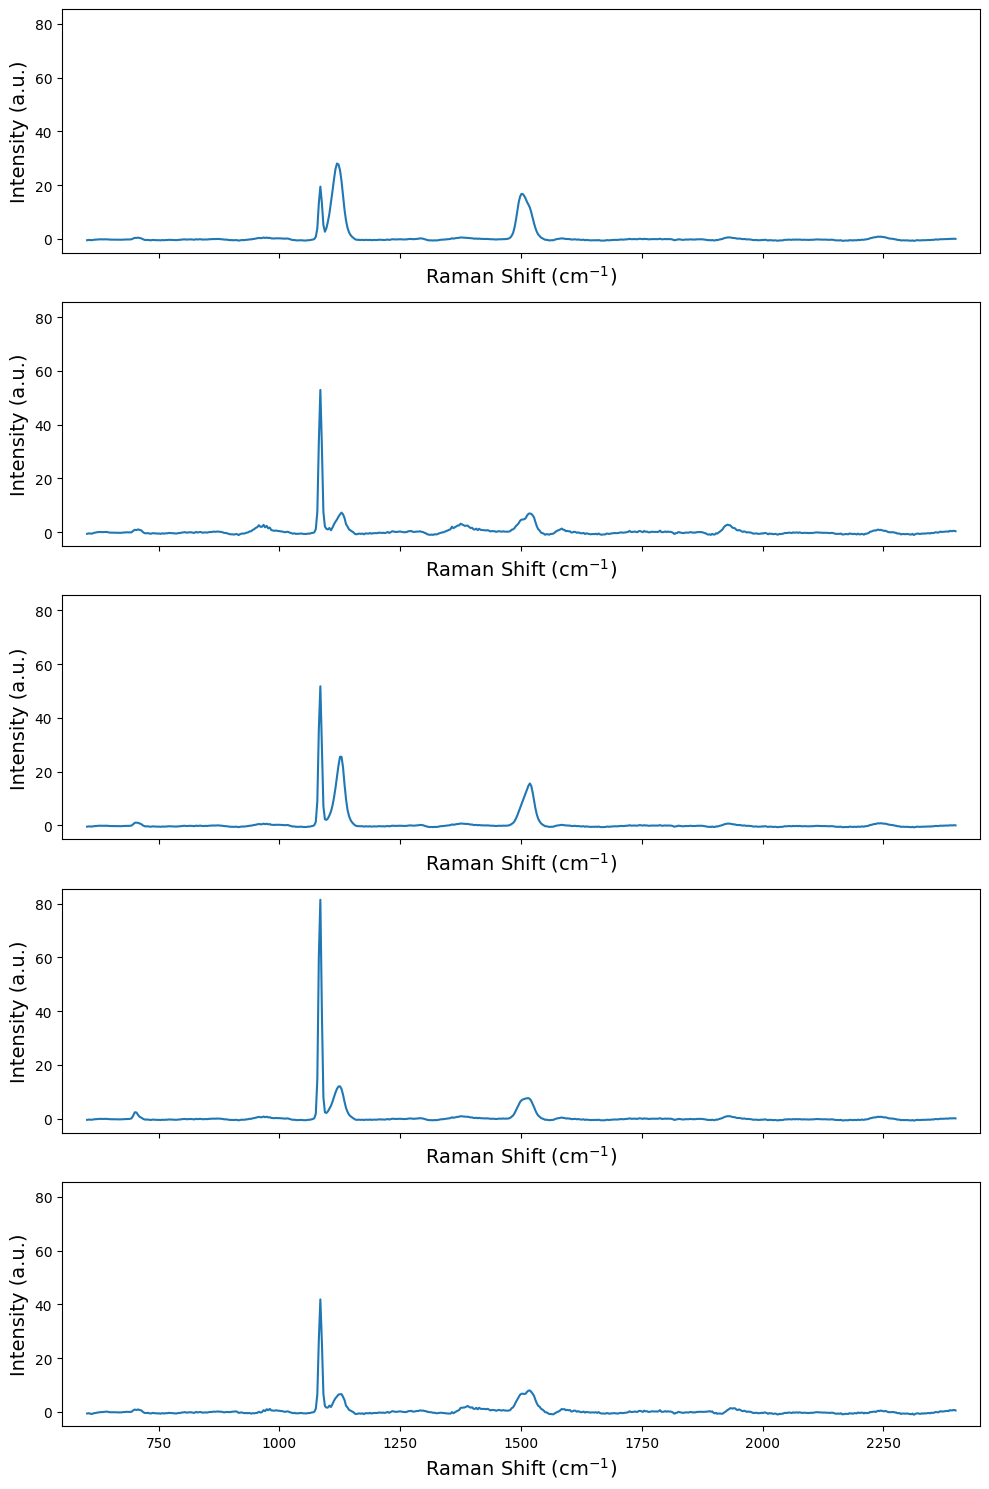

In [52]:
# Suponiendo que ya tienes:
# centroids: array de shape (n_clusters, n_wavenumbers)
# wn: array de longitud n_wavenumbers

n_clusters = len(centroids)
n_cols = 1                  # Número de columnas de la rejilla
n_rows = int(np.ceil(n_clusters / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 3*n_rows), sharex=True, sharey=True)
axes = axes.flatten()
mask = (wn >= 600) & (wn <= 2400)
wn_range = wn[mask]
for i, centro in enumerate(centroids):
    ax = axes[i]
    centro_range = centro[mask]
    ax.plot(wn_range, centro_range)
    
    ax.set_xlabel('Raman Shift (cm$^{-1}$)',fontsize=14)
    ax.set_ylabel('Intensity (a.u.)',fontsize=14)
    ax.set_xlim(550, 2450)

# Si hay ejes vacíos (cuando n_clusters < n_rows*n_cols), los eliminamos:
for j in range(n_clusters, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [73]:
DATA_PCA= SNV(data_sonda_2023_Matlab_copy)
DATA_PCA

178.6  \
Instrumento Muestra  Tipo    Fecha Hora Archivo          X      Y      Cluster_KMeans             
Sonda 523nm LIT235.3 preproc 2023  0    arq235_preproc   72.384 9.042  3               1.545162   
                                                         72.434 9.042  3               1.544158   
                                                         72.484 9.042  3               1.515373   
                                                         72.534 9.042  3               1.595242   
                                                         72.584 9.042  3               1.513747   
...                                                                                         ...   
            LIT6     preproc 2023  0    moderna6_preproc 97.969 10.842 2              -0.022581   
                                                         97.994 10.842 2               0.089754   
                                                         98.019 10.842 2               0.086251   
                                                         98.044 10.842 2              -0.177890   
                                                         98.069 10.842 2              -0.256411   

                                                                                         182.29  \
Instrumento Muestra  Tipo    Fecha Hora Archivo          X      Y      Cluster_KMeans             
Sonda 523nm LIT235.3 preproc 2023  0    arq235_preproc   72.384 9.042  3               1.377188   
                                                         72.434 9.042  3               1.277396   
                                                         72.484 9.042  3               0.886986   
                                                         72.534 9.042  3               1.542916   
                                                         72.584 9.042  3               1.378429   
...                                                                                         ...   
            LIT6     preproc 2023  0    moderna6_preproc 97.969 10.842 2              -0.146602   
                                                         97.994 10.842 2              -0.011632   
                                                         98.019 10.842 2              -0.289999   
                                                         98.044 10.842 2              -0.087000   
                                                         98.069 10.842 2              -0.173191   

                                                                                         185.98  \
Instrumento Muestra  Tipo    Fecha Hora Archivo          X      Y      Cluster_KMeans             
Sonda 523nm LIT235.3 preproc 2023  0    arq235_preproc   72.384 9.042  3               0.821419   
                                                         72.434 9.042  3               1.022911   
                                                         72.484 9.042  3               0.806260   
                                                         72.534 9.042  3               1.177893   
                                                         72.584 9.042  3               1.170115   
...                                                                                         ...   
            LIT6     preproc 2023  0    moderna6_preproc 97.969 10.842 2              -0.176196   
                                                         97.994 10.842 2               0.048932   
                                                         98.019 10.842 2              -0.214786   
                                                         98.044 10.842 2              -0.271550   
                                                         98.069 10.842 2              -0.330868   

                                                                                         189.67  \
Instrumento Muestra  Tipo    Fecha Hora Archivo          X      Y      Cluster_KMeans             
Sonda 523nm LIT235.3 preproc

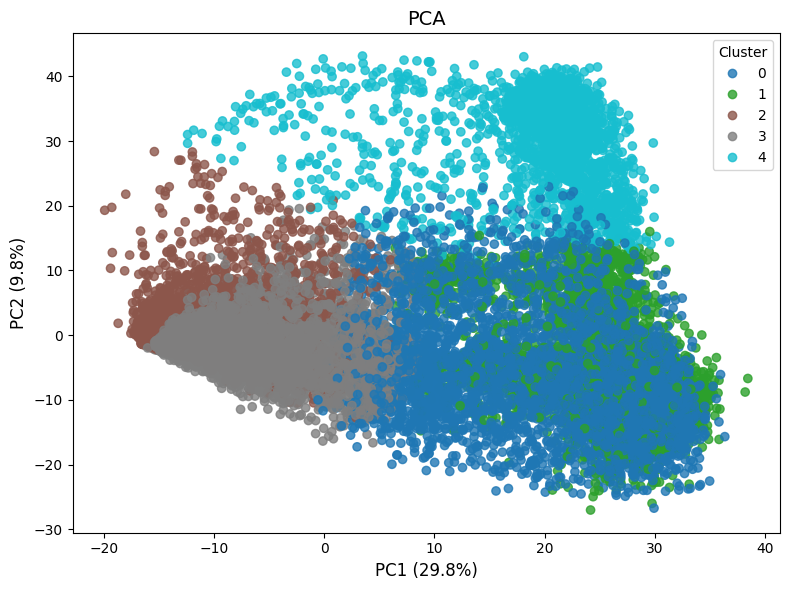

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Ajusta estas variables a tu entorno ---
# DataFrame con tus espectros SNV (sin columna de cluster):
df_snv = DATA_PCA
# Número deseado de clusters:
n_clusters = 5  
# ----------------------------------------

# 1) Matriz de datos
X = df_snv.values

# 2) Escalado (recomendado antes de PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) K-Means para etiquetas
kmeans = KMeans(n_clusters=n_clusters, random_state=50)
labels = kmeans.fit_predict(X_scaled)

# 4) PCA a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 5) Gráfico
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=labels, cmap='tab10', alpha=0.8
)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
plt.title('PCA', fontsize=14)
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.tight_layout()
plt.show()

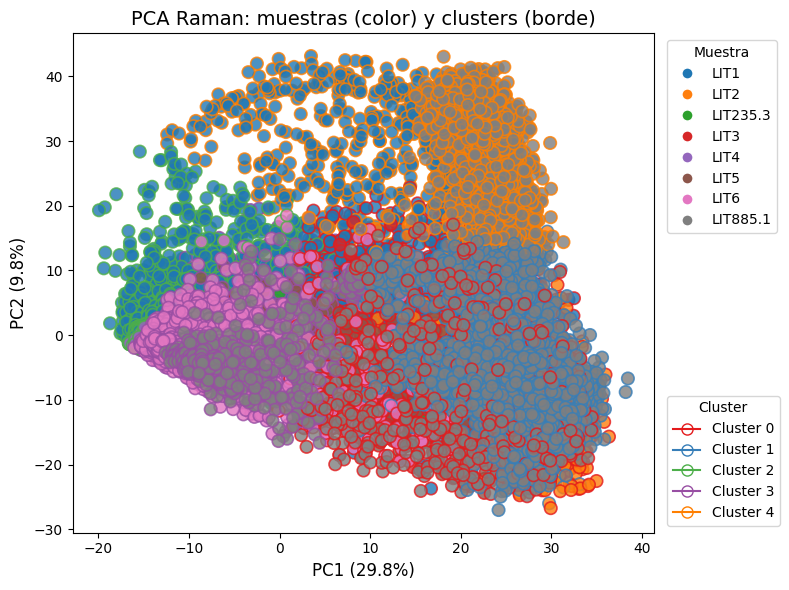

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D

# — Ajusta estas variables ——————————————
df_snv     = DATA_PCA                     # tu DataFrame normalizado
n_clusters = 5                             # número de clusters
# Obtenemos el nombre/etiqueta de cada espectro:
muestras   = df_snv.index.get_level_values('Muestra').astype(str)
# ————————————————————————————————

# 1) Escalado y clustering
X        = df_snv.values
X_scaled = StandardScaler().fit_transform(X)
labels   = KMeans(n_clusters=n_clusters, random_state=50).fit_predict(X_scaled)

# 2) PCA a 2 componentes
X_pca = PCA(n_components=2).fit_transform(X_scaled)
var1, var2 = PCA(n_components=2).fit(X_scaled).explained_variance_ratio_

# 3) Prepara paletas
unique_ms = sorted(set(muestras))
unique_cl = np.unique(labels)

cmap_ms = plt.get_cmap('tab10')    # para muestras
cmap_cl = plt.get_cmap('Set1')     # para clusters

sample_colors = {ms: cmap_ms(i) for i, ms in enumerate(unique_ms)}
cluster_colors = {cl: cmap_cl(i) for i, cl in enumerate(unique_cl)}

# 4) Dibuja el scatter
fig, ax = plt.subplots(figsize=(8,6))

for ms in unique_ms:
    mask = (muestras == ms)
    fc = sample_colors[ms]
    # borde de cada punto según su cluster
    edgecols = [cluster_colors[lab] for lab in labels[mask]]
    ax.scatter(
        X_pca[mask,0], X_pca[mask,1],
        facecolor=fc,
        edgecolor=edgecols,
        linewidth=1.2,
        s=80,
        alpha=0.8,
        label=ms  # solo para legend_samples
    )

# 5) Leyenda muestras (colores de relleno)
handles_ms = [
    Line2D([0],[0],
           marker='o', color='w',
           markerfacecolor=sample_colors[ms],
           markersize=8,
           label=ms)
    for ms in unique_ms
]
leg_ms = ax.legend(
    handles=handles_ms,
    title='Muestra',
    loc='upper left',
    bbox_to_anchor=(1.01, 1)
)

# 6) Leyenda clusters (bordes)
handles_cl = [
    Line2D([0],[0],
           marker='o', color=cluster_colors[cl],
           markerfacecolor='none',
           linewidth=1.5,
           markersize=8,
           label=f'Cluster {cl}')
    for cl in unique_cl
]
leg_cl = ax.legend(
    handles=handles_cl,
    title='Cluster',
    loc='lower left',
    bbox_to_anchor=(1.01, 0)
)

ax.add_artist(leg_ms)  # para mantener ambas leyendas

# 7) Etiquetas y título
ax.set_xlabel(f'PC1 ({var1*100:.1f}%)', fontsize=12)
ax.set_ylabel(f'PC2 ({var2*100:.1f}%)', fontsize=12)
ax.set_title('PCA Raman: muestras (color) y clusters (borde)', fontsize=14)
plt.tight_layout()
plt.show()


In [77]:
DATA_PCA

178.6  \
Instrumento Muestra  Tipo    Fecha Hora Archivo          X      Y      Cluster_KMeans             
Sonda 523nm LIT235.3 preproc 2023  0    arq235_preproc   72.384 9.042  3               1.545162   
                                                         72.434 9.042  3               1.544158   
                                                         72.484 9.042  3               1.515373   
                                                         72.534 9.042  3               1.595242   
                                                         72.584 9.042  3               1.513747   
...                                                                                         ...   
            LIT6     preproc 2023  0    moderna6_preproc 97.969 10.842 2              -0.022581   
                                                         97.994 10.842 2               0.089754   
                                                         98.019 10.842 2               0.086251   
                                                         98.044 10.842 2              -0.177890   
                                                         98.069 10.842 2              -0.256411   

                                                                                         182.29  \
Instrumento Muestra  Tipo    Fecha Hora Archivo          X      Y      Cluster_KMeans             
Sonda 523nm LIT235.3 preproc 2023  0    arq235_preproc   72.384 9.042  3               1.377188   
                                                         72.434 9.042  3               1.277396   
                                                         72.484 9.042  3               0.886986   
                                                         72.534 9.042  3               1.542916   
                                                         72.584 9.042  3               1.378429   
...                                                                                         ...   
            LIT6     preproc 2023  0    moderna6_preproc 97.969 10.842 2              -0.146602   
                                                         97.994 10.842 2              -0.011632   
                                                         98.019 10.842 2              -0.289999   
                                                         98.044 10.842 2              -0.087000   
                                                         98.069 10.842 2              -0.173191   

                                                                                         185.98  \
Instrumento Muestra  Tipo    Fecha Hora Archivo          X      Y      Cluster_KMeans             
Sonda 523nm LIT235.3 preproc 2023  0    arq235_preproc   72.384 9.042  3               0.821419   
                                                         72.434 9.042  3               1.022911   
                                                         72.484 9.042  3               0.806260   
                                                         72.534 9.042  3               1.177893   
                                                         72.584 9.042  3               1.170115   
...                                                                                         ...   
            LIT6     preproc 2023  0    moderna6_preproc 97.969 10.842 2              -0.176196   
                                                         97.994 10.842 2               0.048932   
                                                         98.019 10.842 2              -0.214786   
                                                         98.044 10.842 2              -0.271550   
                                                         98.069 10.842 2              -0.330868   

                                                                                         189.67  \
Instrumento Muestra  Tipo    Fecha Hora Archivo          X      Y      Cluster_KMeans             
Sonda 523nm LIT235.3 preproc

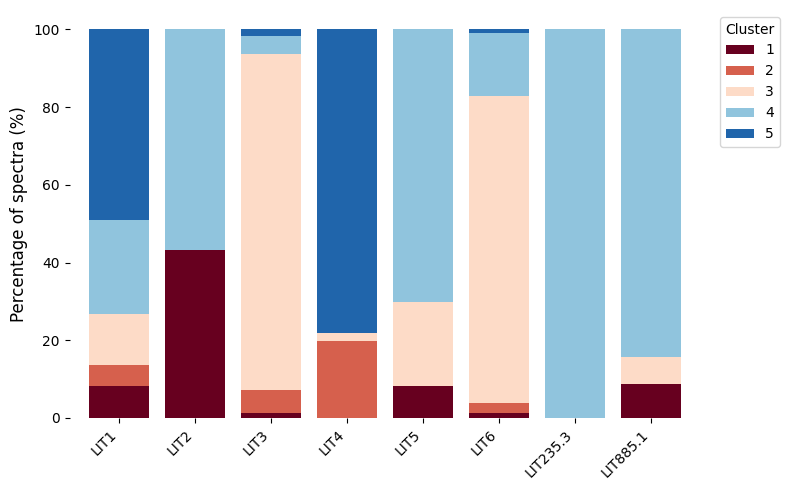

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

# — Datos de entrada —
df = DATA_PCA.copy()
muestras_ordenadas = [
    'LIT1','LIT2','LIT3','LIT4',
    'LIT5','LIT6','LIT235.3','LIT885.1'
]

# 1) Monta df_dist y desplaza los clusters para que empiecen en 1
df_dist = pd.DataFrame({
    'Muestra': df.index.get_level_values('Muestra'),
    'Cluster': df.index.get_level_values('Cluster_KMeans').astype(int) + 1
})

# 2) Cuenta y convierte a porcentaje por muestra
tabla = df_dist.groupby(['Muestra','Cluster']).size().unstack(fill_value=0)
porc  = tabla.div(tabla.sum(axis=1), axis=0) * 100

# 3) Reordena filas
porc = porc.reindex(index=muestras_ordenadas).fillna(0)

# 4) Define tus colores (uno por cluster 1–5)
colors = [
    '#67001f',  # Cluster 1
    '#b2182b',  # Cluster 2
    '#d6604d',  # Cluster 3
    '#f4a582',  # Cluster 4
    '#fddbc7'   # Cluster 5
]
colors = [
    '#67001f',  # Cluster 1
    '#d6604d',  # Cluster 2
    '#fddbc7',  # Cluster 3
    '#90c4dd',  # Cluster 4
    '#2065ab'   # Cluster 5
]

# 5) Plot
fig, ax = plt.subplots(figsize=(8,5))
porc.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    edgecolor='none',
    width=0.8
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_ylabel('Percentage of spectra (%)', fontsize=12)
ax.set_xlabel(None)
ax.legend(
    title='Cluster',
    bbox_to_anchor=(1.02,1),
    loc='upper left'
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



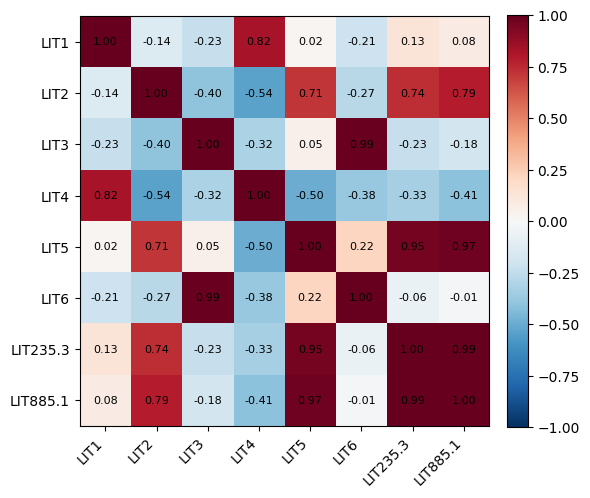

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 0) Lista con el orden deseado de las muestras
muestras_ordenadas = ['LIT1', 'LIT2', 'LIT3', 'LIT4',
                      'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']

# ——————————————————————————————————————————————————————————————
# Suponiendo que ya has calculado el DataFrame 'porc'
#   índice = muestras, columnas = [0,1,2,3,4], valores = % de espectros
# ——————————————————————————————————————————————————————————————

# 1) Reordenamos 'porc' según tu lista (ignora si alguna falta)
porc = porc.reindex(index=muestras_ordenadas).fillna(0)

# 2) Calculamos la matriz de Pearson entre filas (conchas)
#    Trasponemos y usamos .corr() para obtener correlación ROW vs ROW
corr_df = porc.T.corr().reindex(index=muestras_ordenadas,
                                columns=muestras_ordenadas)

# 3) Heatmap
fig, ax = plt.subplots(figsize=(6,6))
cax = ax.imshow(corr_df.values, vmin=-1, vmax=1, cmap='RdBu_r')
ax.set_xticks(range(len(muestras_ordenadas)))
ax.set_xticklabels(muestras_ordenadas, rotation=45, ha='right')
ax.set_yticks(range(len(muestras_ordenadas)))
ax.set_yticklabels(muestras_ordenadas)
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
for (i, row) in enumerate(corr_df.values):
    for (j, val) in enumerate(row):
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black", fontsize=8)
plt.tight_layout()
plt.show()


Text(24.722222222222214, 0.5, '')

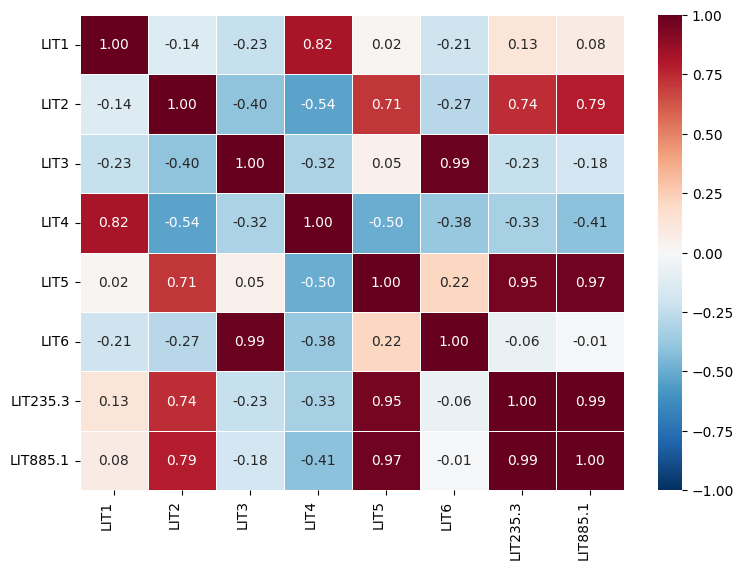

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Asegúrate del orden de las muestras
muestras_ordenadas = ['LIT1','LIT2','LIT3','LIT4',
                      'LIT5','LIT6','LIT235.3','LIT885.1']
porc = porc.reindex(index=muestras_ordenadas)

# 2) Calcula la matriz de correlación Pearson entre filas (conchas)
corr = porc.T.corr()  # índice y columnas: muestras

# 3) Crea una máscara para la mitad superior (o inferior)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# 4) Dibuja el heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    mask=None,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    linewidths=0.5
)

plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.xlabel(None)
plt.ylabel(None)

In [82]:
import pandas as pd

# Lista con el orden deseado
muestras_ordenadas = ['LIT1','LIT2','LIT3','LIT4',
                      'LIT5','LIT6','LIT235.3','LIT885.1']

# Asegúrate de que 'porc' tiene ese índice en ese orden
porc = porc.reindex(index=muestras_ordenadas)

# Nombres de las dos últimas muestras
targets = muestras_ordenadas[-2:]  # ['LIT235.3', 'LIT885.1']

# Construimos un dict con la correlación de cada target vs todas
corr_dict = {
    tgt: {m: porc.loc[tgt].corr(porc.loc[m])
          for m in muestras_ordenadas}
    for tgt in targets
}

# Lo pasamos a DataFrame
corr_df = pd.DataFrame(corr_dict, index=muestras_ordenadas)

print("Coeficientes de Pearson de las dos últimas muestras vs el resto:\n")
print(corr_df.round(3))

Coeficientes de Pearson de las dos últimas muestras vs el resto:

          LIT235.3  LIT885.1
LIT1         0.131     0.079
LIT2         0.739     0.786
LIT3        -0.229    -0.183
LIT4        -0.333    -0.408
LIT5         0.953     0.972
LIT6        -0.063    -0.015
LIT235.3     1.000     0.994
LIT885.1     0.994     1.000
